In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import glob
from datetime import datetime as dt
import seaborn as sns
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

np.set_printoptions(suppress=True)

%matplotlib inline

pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

In [2]:
# df_sf_2017 = pickle.load(open('../data_sf_2017.p', 'rb'))

## load 2017 data plus additional manipulations

In [146]:
df_sf_2017 = pd.read_json('df_sf_2017')
df_sf_2017.loc[df_sf_2017.cancellation_policy == 'flexible_new', 'cancellation_policy'] = "flexible"
prop_type = set(df_sf_2017.property_type.values)
keep = ['Apartment', 'House', 'Condomonium']
drop = list(set(prop_type).difference(keep))
df_sf_2017['property_type_new'] = df_sf_2017['property_type']
df_sf_2017.loc[df_sf_2017.property_type.isin(drop), 'property_type_new'] = "Other"


df_sf_2017['amenities_count'] = (df_sf_2017.amenities.apply(lambda x: len(x.split(','))))
df_sf_2017.is_business_travel_ready.fillna(value='f', inplace=True)

df_sf_2017.security_deposit.fillna(value='$0.00', inplace=True)
df_sf_2017['security_deposit'].replace('[\$,]', '', regex=True, inplace=True)
df_sf_2017['security_deposit'] = df_sf_2017.security_deposit.astype(float) 


In [54]:
# df_sf['price'].apply(np.log)[df_sf_2017['price_per_guest'].isnull()][[ 'price', 'guests_included','price_per_guest']]

,price,guests_included,price_per_guest


## Predict 2017

In [3]:
def grid_searching (param_grid, model):

    grid_search = GridSearchCV(model, 
                               param_grid=param_grid, cv=5, 
                               n_jobs=-1, scoring=make_scorer(f1_score))
    fit = grid_search.fit(X_train, y_train)
    predicted = fit.predict(X_test)
    return grid_search.best_params_


## Random Forest

In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle

In [215]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']


    return X_train, y_train, X_test, y_test
    

In [216]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

## Label encoder is not sufficient. Need OneHotEncoder. 

In [217]:
# def transform_data(X):
#     X['extra_people'].replace('[\=$,]', '', regex=True, inplace=True)
# #     X['price'].replace('[\=$,]', '', regex=True, inplace=True)
#     X['property_type_new'] = le.fit_transform(X['property_type_new'])
#     X['bed_type'] = le.fit_transform(X['bed_type'])
#     X['cancellation_policy'] = le.fit_transform(X['cancellation_policy'])
#     X['room_type'] = le.fit_transform(X['room_type'])
 
#     return X

In [218]:
def predict_data(X_train, y_train, X_test, y_test):
    
    param_grid = {'n_estimators': [500, 1000, 1500], 
                  'max_features': ['auto'], 
                  'max_depth': [None, 15],
                  'class_weight': [None, {0: .8, 1: .2}, {0: .9, 1: .1}, {0: .99, 1: .01}]}

    model = RandomForestClassifier()
    
    best_parameters = grid_searching(param_grid, model)
    print(best_parameters)
    rf = RandomForestClassifier(n_estimators = best_parameters['n_estimators'], n_jobs=-1, random_state=0, max_depth = best_parameters['max_depth'], class_weight = best_parameters['class_weight'])
#     rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=0, class_weight = {0: .99, 1: .01})
   
    rf.fit(X_train, y_train)
    
    predicted = rf.predict(X_test)
    pickle.dump(rf, open('rf_model'+ str(model_num) + '.p', 'wb'))
    scores[0][model_num] = accuracy_score(y_test, predicted)
    scores[1][model_num] = recall_score(y_test, predicted)
    scores[2][model_num] = precision_score(y_test, predicted)
    scores[3][model_num] = f1_score(y_test, predicted)
    return scores, rf

In [219]:
scores = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4
# columns_to_keep = ['accommodates','bed_type', 'extra_people', 'price','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type']
# columns_to_keep = ['accommodates','bed_type', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type']


##USED THIS ONE EARLIER
# columns_to_keep = ['access_filled', 'house_rules_filled','space_filled','accommodates','bed_type', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type', 'property_type_new']

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

#THIS IS A TEST ONE
# columns_to_keep = ['accommodates','bed_type', 'extra_people', 'price_per_guest','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type', 'property_type_new']

In [220]:
%%time
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_dummify(X_train, columns_to_keep)
    X_test = transform_dummify(X_test, columns_to_keep)
    scores, rf = predict_data(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores)

{'class_weight': {0: 0.9, 1: 0.1}, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
1 4 0
[[0.95546093 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.83913329 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9        0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86850153 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
{'class_weight': {0: 0.8, 1: 0.2}, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 1500}
2 5 1
[[0.95546093 0.95561927 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.83913329 0.80615586 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9        0.9311649  0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86850153 0.86416286 0.         0.         0.         0.
  0.         0.         0.        ]]
{'class_weight': {0

In [36]:
rf.feature_importances_

array([0.06298378, 0.08306105, 0.14016737, 0.06854805, 0.01724184,
       0.0162712 , 0.01174779, 0.03962629, 0.04995908, 0.11376256,
       0.10291359, 0.02259193, 0.01454926, 0.00002521, 0.00447527,
       0.0079494 , 0.00843629, 0.00173774, 0.00128972, 0.00053786,
       0.00857463, 0.00425902, 0.00224656, 0.001592  , 0.0007168 ,
       0.00683727, 0.00526871, 0.00443224, 0.00128733, 0.00543711,
       0.01230759, 0.0051497 , 0.00717714, 0.00330212, 0.00392734,
       0.00407751, 0.00544476, 0.00679873, 0.00345549, 0.00477406,
       0.00443258, 0.0001718 , 0.00106553, 0.00348224, 0.00083475,
       0.00812534, 0.0003513 , 0.00271218, 0.00196307, 0.00333152,
       0.00886603, 0.00083974, 0.00040641, 0.00182488, 0.00156437,
       0.00329549, 0.0114112 , 0.01369772, 0.01144166, 0.00017974,
       0.00001575, 0.00935145, 0.00915301, 0.00251632, 0.01325751,
       0.01267412, 0.00809289])

In [51]:
# from tempfile import TemporaryFile
# scores_rf_baseline = TemporaryFile()
# np.save(scores_rf_baseline,scores)x

In [53]:
# scores_rf_baseline.seek(0) # Only needed here to simulate closing & reopening file
# np.load(scores_rf_baseline)

array([[0.81988506, 0.89212093, 0.88964655, 0.88999322, 0.88094975,
        0.88061452, 0.88234636, 0.88732079, 0.85575529],
       [0.2336272 , 0.47006931, 0.48648649, 0.4973822 , 0.47533875,
        0.49067661, 0.49973698, 0.53308824, 0.5445224 ],
       [0.51456311, 0.88075561, 0.87473002, 0.88601036, 0.88855117,
        0.93692777, 0.9047619 , 0.89664311, 0.86982759],
       [0.32135123, 0.61298274, 0.62524122, 0.63710879, 0.61935028,
        0.64405594, 0.64384954, 0.66864295, 0.66976435]])

In [221]:
accuracy_2017 = np.mean(scores[0])
recall_2017 = np.mean(scores[1])
precision_2017 = np.mean(scores[2])
f1_score_2017 = np.mean(scores[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9510394426862019
0.8367017636067986
0.9132446844769156
0.8729239273514097


In [133]:
rf_permutation_importance = permutation_importance(rf, np.array(X_test), np.array(y_test), scorer=f1_score)
rf_permutation_importance

array([ 0.02554822,  0.04584343,  0.22714524,  0.13286182,  0.02121073,
        0.0324306 ,  0.01140432,  0.01180934,  0.02758485,  0.13297079,
        0.04182354,  0.01009677,  0.00776263,  0.        ,  0.02239319,
        0.1113051 ,  0.00056179,  0.00262223, -0.00021223,  0.00077337,
        0.00086122,  0.        , -0.00051193,  0.00330904,  0.00008726,
        0.        ,  0.        ,  0.0042667 ,  0.0015478 ,  0.0009492 ,
        0.        ,  0.00193541,  0.00513707,  0.00193541,  0.00211302,
        0.00038655,  0.00086122,  0.00077337,  0.00107242,  0.00408601,
        0.00107242,  0.00128319,  0.00077337,  0.        ,  0.        ,
        0.0012486 ,  0.        ,  0.00241234,  0.        ,  0.        ,
        0.00038655,  0.0015478 ,  0.00038655,  0.        ,  0.        ,
        0.00077337,  0.        ,  0.        ,  0.00732966,  0.01099762,
        0.00354927,  0.        ,  0.        ,  0.00955487,  0.00472061,
        0.00077337,  0.00430242,  0.00960535,  0.00378738,  0.01

In [142]:
X_train.columns

Index(['host_length', 'amenities_count', 'review_scores_rating',
       'host_response_rate', 'access_filled', 'house_rules_filled',
       'space_filled', 'accommodates', 'extra_people', 'price_per_guest',
       'price_per_bedroom', 'guests_included', 'host_about_filled',
       'host_picture_url_filled', 'calculated_host_listings_count',
       'minimum_nights', 'neighbourhood_cleansed_Bayview',
       'neighbourhood_cleansed_Bernal Heights',
       'neighbourhood_cleansed_Castro/Upper Market',
       'neighbourhood_cleansed_Chinatown',
       'neighbourhood_cleansed_Crocker Amazon',
       'neighbourhood_cleansed_Diamond Heights',
       'neighbourhood_cleansed_Downtown/Civic Center',
       'neighbourhood_cleansed_Excelsior',
       'neighbourhood_cleansed_Financial District',
       'neighbourhood_cleansed_Glen Park',
       'neighbourhood_cleansed_Golden Gate Park',
       'neighbourhood_cleansed_Haight Ashbury',
       'neighbourhood_cleansed_Inner Richmond',
       'neighbourh

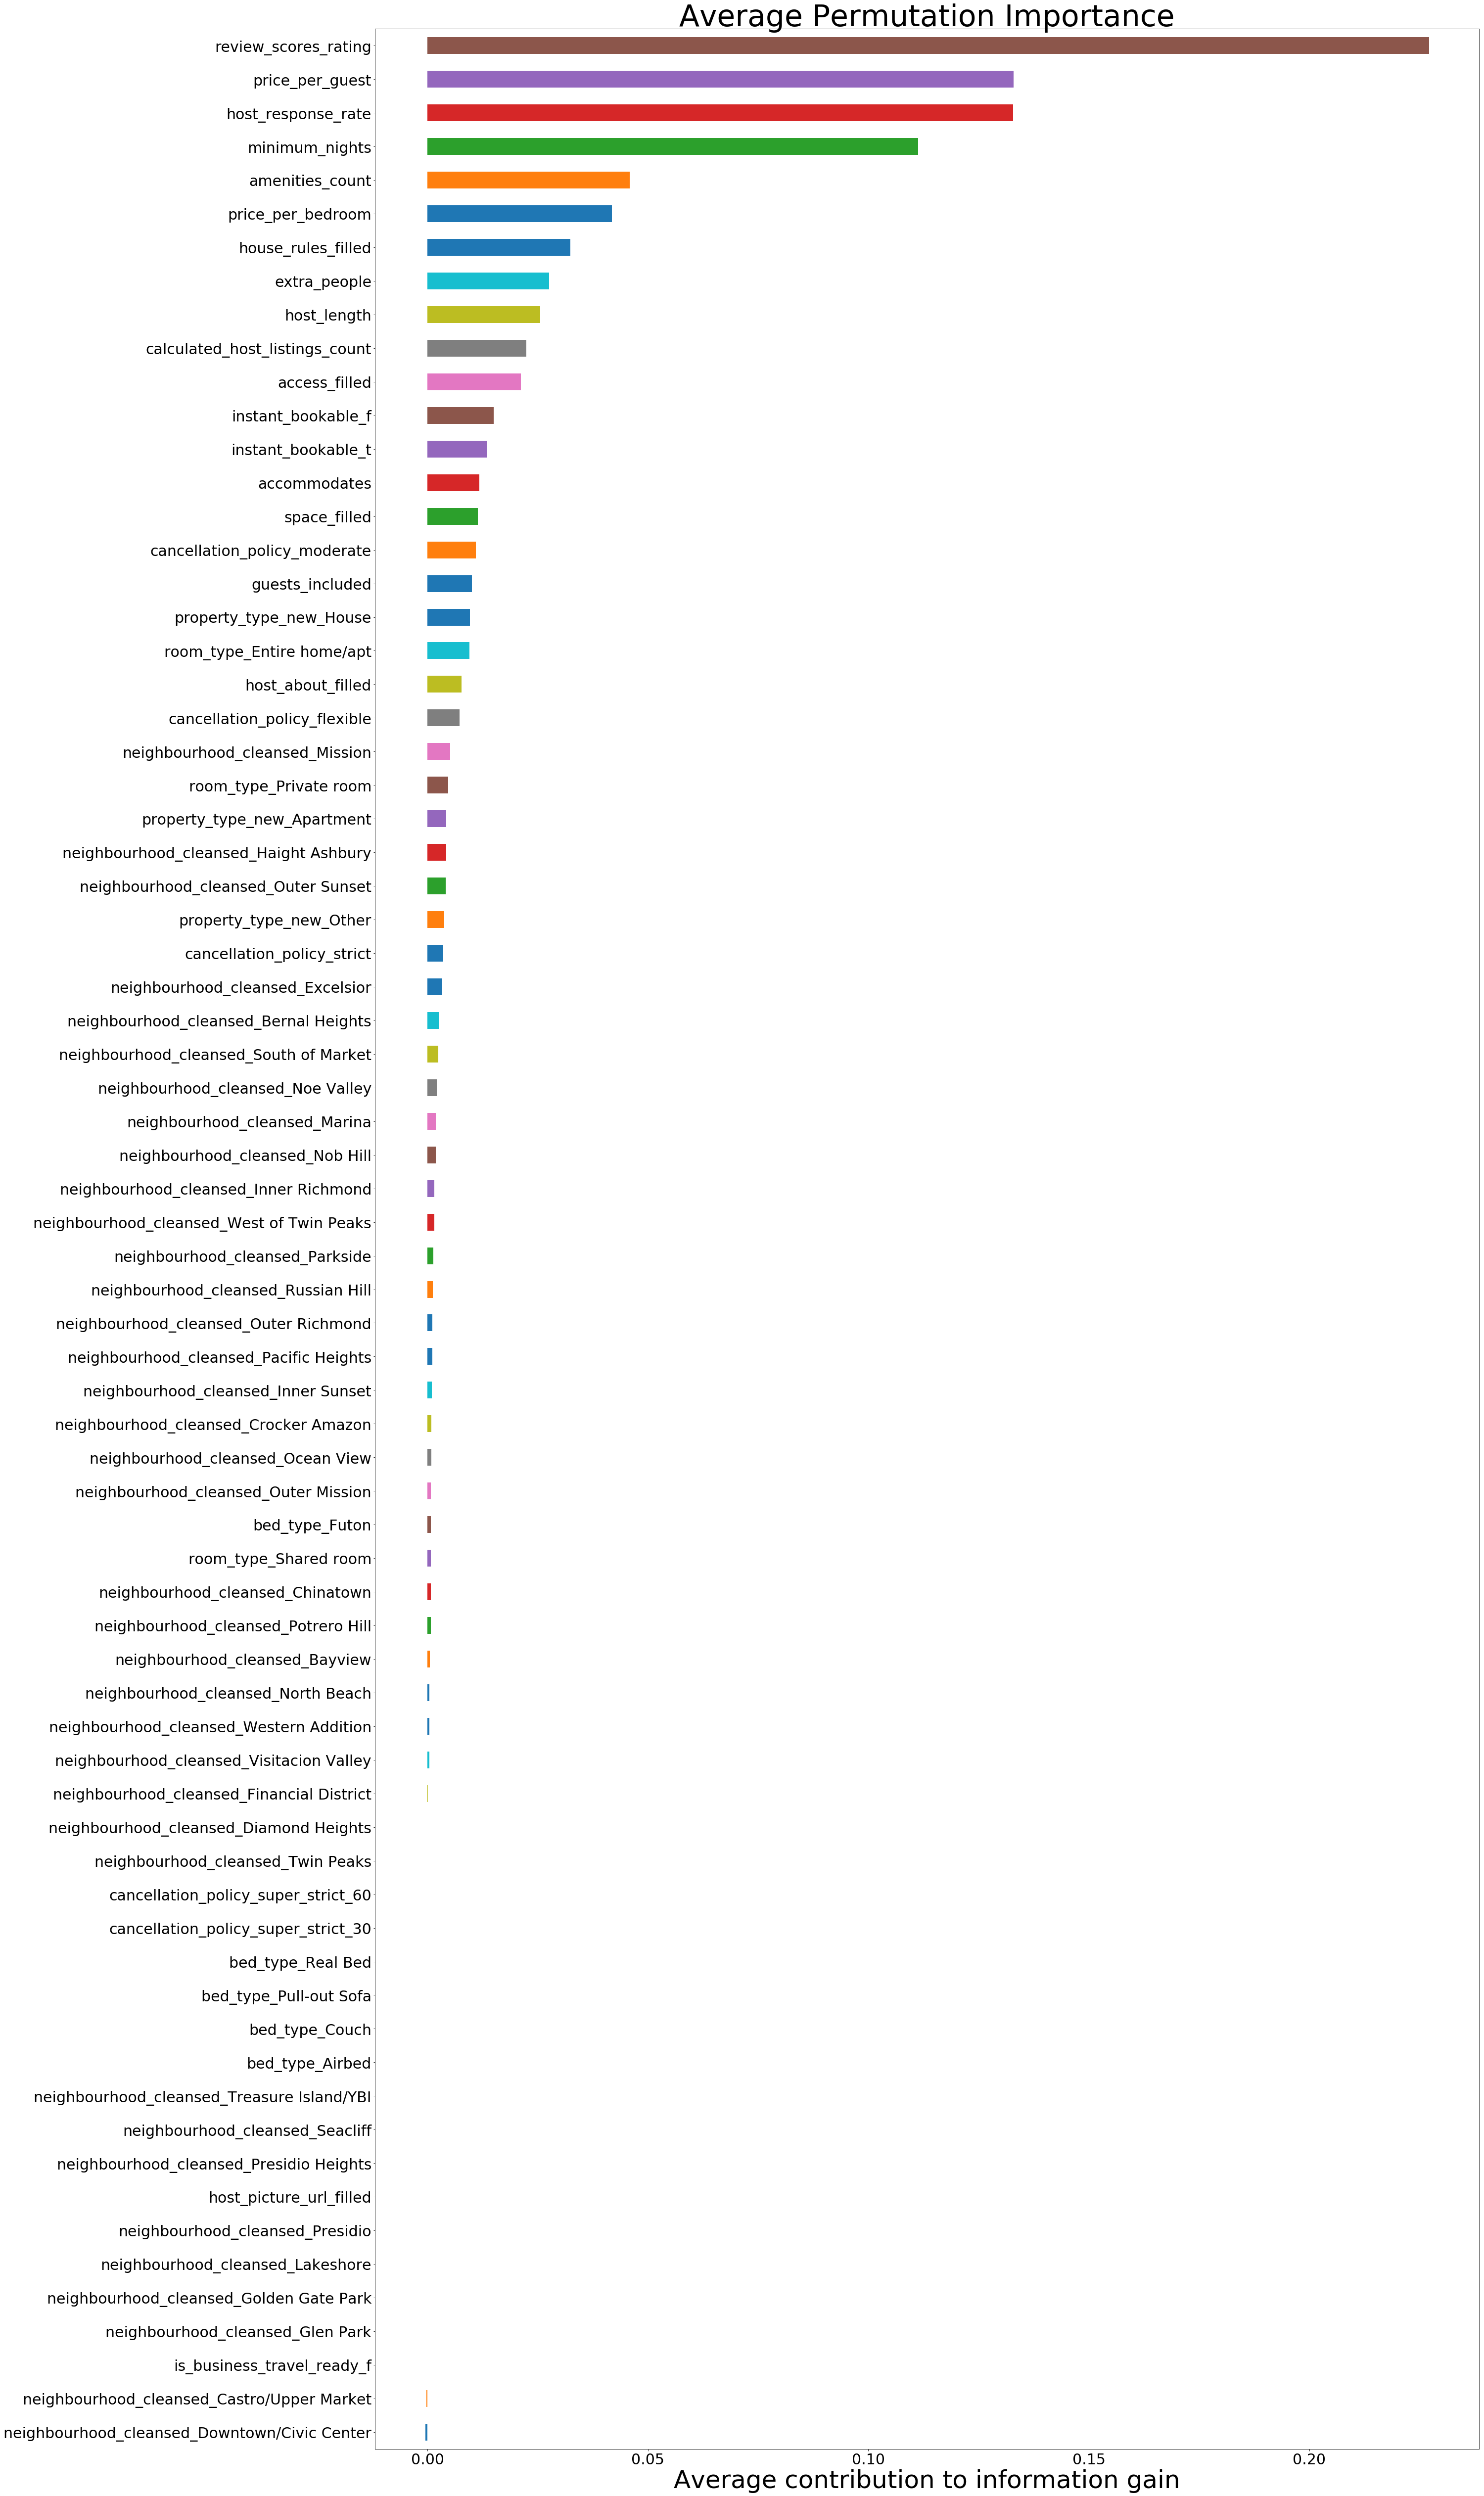

In [156]:
b_feat_scores = pd.Series(rf_permutation_importance,
                           index=X_train.columns)
b_feat_scores = b_feat_scores.sort_values()
ax = b_feat_scores.plot(kind='barh', figsize=(40,90), fontsize=30)
ax.set_title('Average Permutation Importance', fontsize=60)
ax.set_xlabel('Average contribution to information gain',fontsize=50 );

plt.gcf()
plt.savefig('permutation_import')

In [103]:
def permutation_importance(model, X_test, y_test, scorer=accuracy_score):
    ''' Calculates permutation feature importance for a fitted model
    
    Parameters
    ----------
    model: anything with a predict() method
    X_test, y_test: numpy arrays of data
        unseen by model
    scorer: function. Should be a "higher is better" scoring function,
        meaning that if you want to use an error metric, you should
        multiply it by -1 first.
        ex: >> neg_mse = lambda y1, y2: -mean_squared_error(y1, y2)
            >> permutation_importance(mod, X, y, scorer=neg_mse)
    
    Returns
    -------
    feat_importances: numpy array of permutation importance
        for each feature
    
    '''
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, i)
        test_score_permuted = scorer(model.predict(X_test_shuffled), y_test)
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

In [104]:
def shuffle_column(X, feature_index):
    ''' 
    Parameters
    ----------
    X: numpy array
    feature_index: int
    
    Returns
    -------
    X_new: numpy array
    
    Returns a new array identical to X but
    with all the values in column feature_index
    shuffled
    '''   
    
    X_new = X.copy()
    np.random.shuffle(X_new[:,feature_index])
    return X_new    

## XGBoost for 2017

In [49]:
from xgboost import XGBClassifier

In [50]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']


    return X_train, y_train, X_test, y_test
    

In [51]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [66]:
def predict_data(X_train, y_train, X_test, y_test):
    
    param_grid = {'learning_rate': [0.1, 0.5, 1, 1.5], 
                 'max_depth': [23, 15]}

    model = XGBClassifier()

    best_params = grid_searching(param_grid, model)

    xgboost = XGBClassifier(n_jobs=-1, booster='gbtree', n_estimators=1000, learning_rate=1, max_depth = best_params['max_depth'], objective='binary:logistic')

    xgboost.fit(X_train, y_train)
    
    predicted = xgboost.predict(X_test)
    pickle.dump(xgboost, open('xgboost_model'+ str(model_num) + '.p', 'wb'))
    scores_xgboost[0][model_num] = accuracy_score(y_test, predicted)
    scores_xgboost[1][model_num] = recall_score(y_test, predicted)
    scores_xgboost[2][model_num] = precision_score(y_test, predicted)
    scores_xgboost[3][model_num] = f1_score(y_test, predicted)
    return xgboost, scores_xgboost

In [63]:
scores_xgboost = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4

In [67]:
%%time
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_dummify(X_train, columns_to_keep)
    X_test = transform_dummify(X_test, columns_to_keep)
    xgboost, scores_xgboost = predict_data(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores_xgboost)

1 4 0
[[0.95649672 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87491727 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.95649672 0.95493119 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.84479371 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.89211618 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87491727 0.86781029 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.95649672 0.95493119 0.95445229 0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.84479371 0.84735202 0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.89211

In [68]:
accuracy_2017 = np.mean(scores_xgboost[0])
recall_2017 = np.mean(scores_xgboost[1])
precision_2017 = np.mean(scores_xgboost[2])
f1_score_2017 = np.mean(scores_xgboost[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9514364355691516
0.8650437931585487
0.8905477616628682
0.8774310061317645


In [28]:
# Add silent=True to avoid printing out updates with each cycle
# predictions = my_model.predict(X_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## XGBoost for one quarter

In [29]:
accuracy_score(y_test, predictions)

0.956496719990793

In [30]:
recall_score(y_test, predictions)

0.8680236375574524

In [31]:
precision_score(y_test, predictions)

0.8819212808539026

In [32]:
f1_score(y_test, predictions)

0.8749172733289211

## KMEANS

In [147]:
from sklearn.cluster import KMeans

In [148]:
columns_to_keep = ['review_scores_rating', 'host_response_rate',  'price_per_guest' ,'minimum_nights']

In [149]:
model_num = 0
start_month = 1
end_month = 4

scores_kmeans = np.zeros(shape=(4,9))

In [150]:
X_train = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)][columns_to_keep]
y_train = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['popular']

X_test = df_sf_2017[df_sf_2017['month'] == end_month][columns_to_keep]
y_test = df_sf_2017[df_sf_2017['month'] == end_month]['popular']


In [151]:
X_train = transform_dummify(X_train, columns_to_keep)
X_test = transform_dummify(X_test, columns_to_keep)

In [152]:
kmeans = KMeans(n_clusters=2, n_jobs=-1)
kmeans.fit(X_train)
predicted = kmeans.predict(X_test)

In [153]:
y = np.array(y_test*1)

In [167]:
y[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [168]:
predicted[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [154]:
accuracy_score(y, predicted)

0.4132811600874669

In [155]:
cm=confusion_matrix(y, predicted)
cm

array([[2068, 5098],
       [   0, 1523]])

In [156]:
recall_score(y, predicted)

1.0

In [213]:
precision_score(y, predicted)

0.23002567587977646

In [158]:
f1_score(y, predicted)

0.3740176817288801

In [211]:
def catPred(kmObj, gTrue, pred): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(50,12))

    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        val = np.unique( gTrue[mask], return_counts=True)
        lbl = val[0]
        ht  = val[1] / val[1].sum()
        if len(np.unique(y_test[mask])) == numClusters:
            ax[i].bar(range(numClusters), height=ht, tick_label = lbl)
        else:
            ax[i].bar(range(1), height=ht, tick_label = lbl)
        ax[i].set_xticklabels(lbl, fontsize=40)
        ax[i].set_title(i, fontsize=50)

        ax[0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8"], fontsize=40)
        ax[0].set_ylabel("Proportion", fontsize = 32);
        plt.suptitle("Proportion of Categories in each Cluster", fontsize = 60);
            
            

In [179]:
mask = (predicted == 0)
print(mask)
val = np.unique(y_test[mask], return_counts=True)
print(val)

[False False False ... False False  True]
(array([False]), array([2068]))


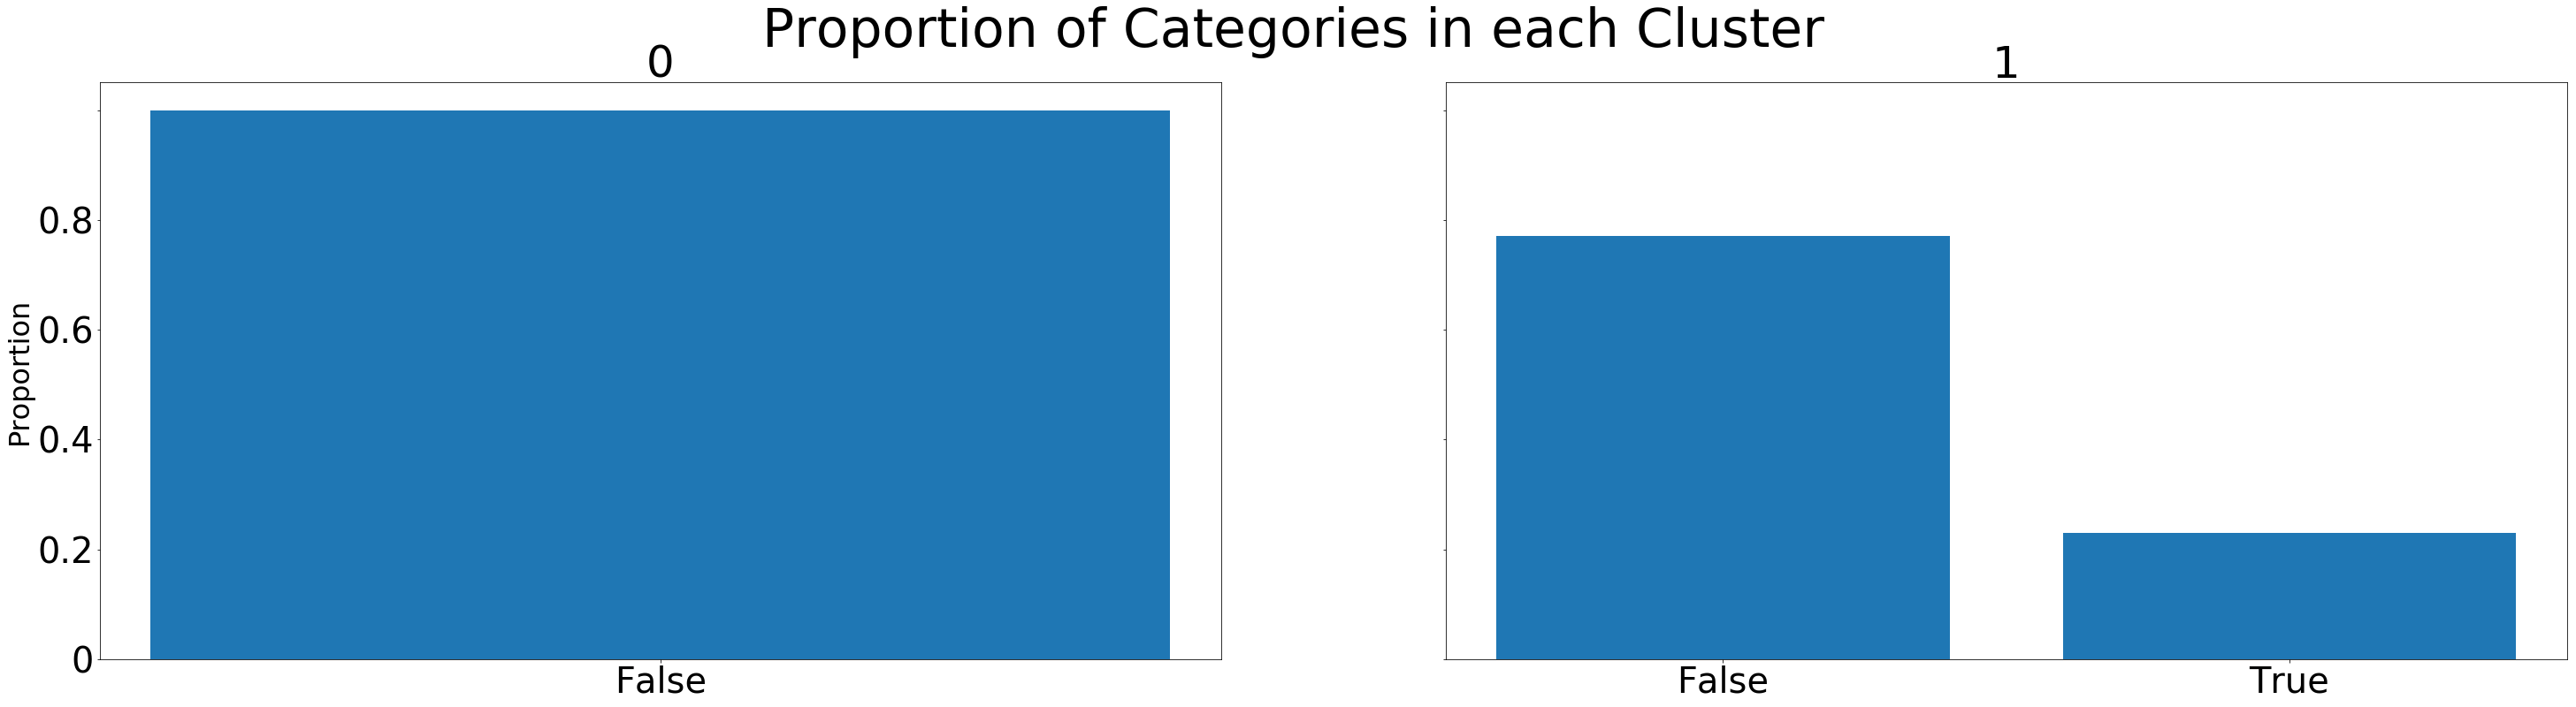

In [212]:
catPred(kmeans, y_test, predicted)

## ADA Boosting with one quarter

In [117]:
from sklearn.ensemble import AdaBoostClassifier #For Classification

In [118]:
param_grid = {'learning_rate': [0.1, 0.5, 1, 1.5, 2]}
model = AdaBoostClassifier()

best_params = grid_searching(param_grid, model)

clf = AdaBoostClassifier(n_estimators = 1000, 
                         learning_rate = best_params['learning_rate']) 
clf.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=1000, random_state=None)

In [119]:
prediction = clf.predict(X_test)

In [120]:
accuracy_score(y_test, prediction)

0.8769708827252849

In [121]:
recall_score(y_test, prediction)

0.571897570584373

In [122]:
precision_score(y_test, prediction)

0.6762422360248447

In [123]:
f1_score(y_test, prediction)

0.6197082888651725

## Gradient Boosting with one quarter

In [121]:
from sklearn.ensemble import GradientBoostingClassifier #For Classification

In [146]:
clf_gradient = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0)
clf_gradient.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [147]:
pred = clf_gradient.predict(X_test)

In [148]:
accuracy_score(y_test, pred)

0.924272068132121

In [149]:
recall_score(y_test, pred)

0.7657430730478589

In [150]:
precision_score(y_test, pred)

0.8095872170439414

In [151]:
f1_score(y_test, pred)

0.7870550161812296

# Logistic Regression (RF was much better)

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']
    
    return X_train, y_train, X_test, y_test
    

In [40]:
def transform_logistic(X, columns_to_keep):

    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column, drop_first=True)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)

    return df_temp

In [41]:
def predict_logistic(X_train, y_train, X_test, y_test):
    model = LogisticRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    beta_coef.append(model.coef_)
    scores_logit[0][model_num] = accuracy_score(y_test, prediction)
    scores_logit[1][model_num] = recall_score(y_test, prediction)
    scores_logit[2][model_num] = precision_score(y_test, prediction)
    scores_logit[3][model_num] = f1_score(y_test, prediction)
    return scores_logit, beta_coef

In [42]:
beta_coef = []
scores_logit = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4

In [43]:
%%time
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_logistic(X_train, columns_to_keep)
    X_test = transform_logistic(X_test, columns_to_keep)
    scores, beta_coef = predict_logistic(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores_logit)
    break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


1 4 0
[[0.83381287 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.16283651 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.59472422 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.2556701  0.         0.         0.         0.         0.
  0.         0.         0.        ]]
CPU times: user 1.07 s, sys: 216 ms, total: 1.28 s
Wall time: 1.26 s


In [23]:
accuracy_2017 = np.mean(scores_logit[0])
recall_2017 = np.mean(scores_logit[1])
precision_2017 = np.mean(scores_logit[2])
f1_score_2017 = np.mean(scores_logit[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.7946514661754123
0.09126554689101034
0.5577129954488265
0.15490514368378314


In [24]:
beta_coef

[array([[ 0.53007962,  0.67561263,  0.15006667,  0.10604996, -0.00633706,
         -1.19853999,  0.18120679, -0.40059964,  0.20662239,  0.55194041,
         -0.62838955, -0.38660583, -0.17662322,  0.09120517,  0.24184857,
         -0.08783601,  0.81886815,  0.49857129, -1.57654837, -0.51161991,
         -0.57295504, -0.21805468, -0.06755512, -0.38932237, -0.08382664,
         -0.38541583]]),
 array([[ 0.4976066 ,  0.61940049,  0.23575569,  0.13464937, -0.00675129,
         -1.5968739 ,  0.19256912, -0.56326032,  0.21077625,  0.62926188,
         -0.63483379, -0.26512533, -0.10449351,  0.24839223,  0.33377135,
         -0.03210413,  0.84458651,  0.566181  , -1.45039404, -0.35055838,
         -0.3713931 , -0.0344765 , -0.01641945, -0.24013341,  0.05059158,
         -0.23274721]]),
 array([[ 0.46440042,  0.62811662,  0.30463579,  0.16218218, -0.00760389,
         -2.00973591,  0.22392864, -0.73386785,  0.24822121,  0.33242678,
         -0.6659505 , -0.10145976, -0.04422087,  0.4338944 ,  

In [14]:
# Compute the change in odds ratio from a one unit change in each feature.

In [143]:
from math import exp
for i, coef in enumerate(model.coef_[0]):
    print("beta%d: %.5f" % (i + 1, exp(coef)))

beta1: 1.69907
beta2: 1.96524
beta3: 1.16191
beta4: 1.11188
beta5: 0.99368
beta6: 0.30163
beta7: 1.19866
beta8: 0.66992
beta9: 1.22952
beta10: 1.73662
beta11: 0.53345
beta12: 0.67936
beta13: 0.83810
beta14: 1.09549
beta15: 1.27360
beta16: 0.91591
beta17: 2.26793
beta18: 1.64637
beta19: 0.20669
beta20: 0.59952
beta21: 0.56386
beta22: 0.80408
beta23: 0.93468
beta24: 0.67752
beta25: 0.91959
beta26: 0.68017


In [ ]:
# Increasing the ____ feature by 1 point increases the chance of being popular by a factor of __ (1.00189).

In [144]:
for i, col in enumerate(list(X_train.columns.values)):
    print(i, col)

0 access_filled
1 house_rules_filled
2 space_filled
3 accommodates
4 extra_people
5 price_per_guest
6 price_per_bedroom
7 guests_included
8 host_about_filled
9 host_picture_url_filled
10 bed_type_Airbed
11 bed_type_Couch
12 bed_type_Futon
13 bed_type_Pull-out Sofa
14 bed_type_Real Bed
15 cancellation_policy_flexible
16 cancellation_policy_moderate
17 cancellation_policy_strict
18 cancellation_policy_super_strict_30
19 cancellation_policy_super_strict_60
20 room_type_Entire home/apt
21 room_type_Private room
22 room_type_Shared room
23 property_type_new_Apartment
24 property_type_new_House
25 property_type_new_Other
